## Feature Type Experiments

### Imports

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from imports import *

2024-09-23 20:04:34.685072: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-23 20:04:37.047245: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-23 20:04:40.690038: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from models import *
from data import * 
from env import *
from harmonize import *
from metrics import * 
from sim import *
from sim import multi_sim_run
from sim import plot

In [3]:
# overall imports
import importlib
import data

# data load
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome
importlib.reload(data.data_load)
importlib.reload(data.data_viz)

# data utils
from data.data_utils import (
    reconstruct_connectome,
    reconstruct_upper_triangle,
    make_symmetric,
    expand_X_symmetric,
    expand_Y_symmetric,
    expand_X_symmetric_shared,
    expand_X_Y_symmetric_conn_only,
    expand_shared_matrices,
    expand_X_symmetric_w_conn, 
    process_cv_splits, 
    process_cv_splits_conn_only_model, 
    expanded_inner_folds_combined_plus_indices
)

import data.data_utils
importlib.reload(data.data_utils)

# cross-validation classes
import data.cv_split
from data.cv_split import RandomCVSplit, SchaeferCVSplit, CommunityCVSplit, SubnetworkCVSplit
importlib.reload(data.cv_split)

# prebuilt model classes
import models.prebuilt_models
from models.prebuilt_models import ModelBuild
importlib.reload(models.prebuilt_models)

# metric classes
import metrics.distance_FC
import metrics.eval
from metrics.eval import ModelEvaluator
from metrics.eval import pearson_numpy, mse_numpy, r2_numpy, pearson_cupy, mse_cupy, r2_cupy
importlib.reload(metrics.eval)


# sim class
import sim.sim 
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
import sim.multi_sim_run
from sim.sim import Simulation
from sim.multi_sim_run import multi_sim_run, single_sim_run, open_pickled_results, combine_results
importlib.reload(sim.sim)
importlib.reload(sim.sim_utils)
importlib.reload(sim.multi_sim_run)

# sim class
import sim.sim 
from sim.sim import Simulation
importlib.reload(sim.sim)


<module 'sim.sim' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim.py'>

In [4]:

total = psutil.disk_usage('/').total
print(bytes2human(total))

GPUtil.getGPUs()

DEVICE_ID_LIST = GPUtil.getFirstAvailable()
DEVICE_ID = DEVICE_ID_LIST[0] # grab first element from list
if DEVICE_ID != None: 
    print('GPU found', DEVICE_ID)
    use_gpu = True

print("XGBoost version:", xgboost.__version__)
print("cupy version:", cp.__version__)

GPUtil.showUtilization()


52.4G
GPU found 0
XGBoost version: 2.0.3
cupy version: 13.1.0
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [5]:
torch.cuda.is_available()

True

[Sims](#sims)

In [6]:
custom_xgb_random_nonshared_sim_results = single_sim_run(
                                              cv_type='random',
                                              model_type='mlp',
                                              feature_type=['transcriptomePCA'],
                                              summary_measure=None,
                                              use_gpu=True,
                                              use_shared_regions=False,
                                              test_shared_regions=False,
                                              save_sim=False,
                                              search_method='bayes'
                                              )

Number of components explaining 95.0% of the variance: 34
self X shape (114, 34)
Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...

 Test fold num: 1
(7140, 68) (7140,) (812, 68) (812,)
2
3
4
Processing fold 0...
Processing fold 1...
Processing fold 2...
MLP input size 68
ACCELERATING
{'base_estimator': 'GP', 'acq_func': 'PI'}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END batch_size=62, dropout=0.4183177229531975, epochs=473, l2_reg=4.2815319280763424e-05, lr=0.0021892527128216433;, score=-0.367 total time=   8.9s
[CV 2/3] END batch_size=62, dropout=0.4183177229531975, epochs=473, l2_reg=4.2815319280763424e-05, lr=0.0021892527128216433;, score=-0.152 total time=   1.2s
[CV 3/3] END batch_size=62, dropout=0.4183177229531975, epochs=473, l2_reg=4.2815319280763424e-05, lr=0.0021892527128216433;, score=-0.228 total time=   1.2s
[CV 1/3] END batch_size=62, dropout=0.3052794004697432, epochs=396, l2_reg=4.063746627400014e-05, lr=0

KeyboardInterrupt: 

In [ ]:
plot.plot_single_model_predictions_with_metrics(custom_xgb_random_nonshared_sim_results)

### Distance

In [57]:
# Extract the coordinates from the DataFrame
coordinates = load_coords()

# Compute pairwise Euclidean distances
distance = squareform(pdist(coordinates, metric='euclidean'))

# Compute inverse of distance so closer regions have higher values
Y_dist = np.array(1/distance)

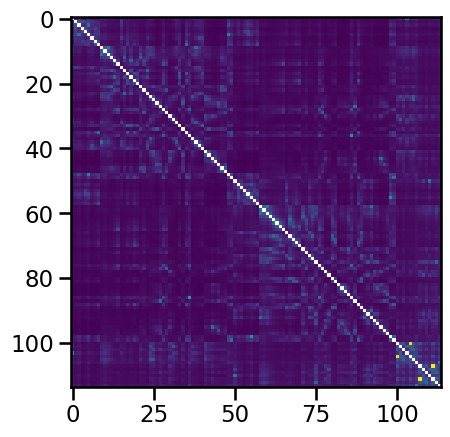

In [58]:
plt.imshow(Y_dist)

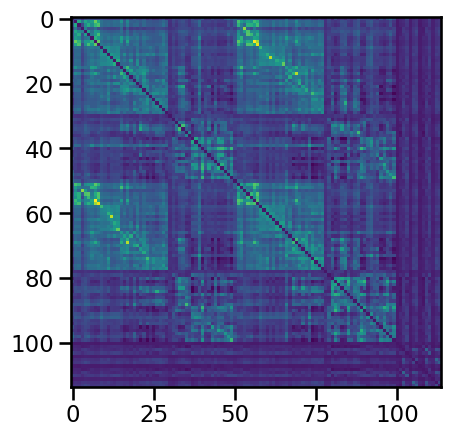

In [59]:
Y_fc = load_connectome()
plt.imshow(Y_fc)

#### Correlate distance-fMRI

In [60]:
# Flatten both matrices to compute the total correlation
np.fill_diagonal(Y_dist, val=0)
Y_dist = Y_dist.flatten()  # if it's a pandas DataFrame
Y_flat = Y_fc.flatten()  # Assuming Y is a numpy array

# Compute Pearson correlation between the flattened matrices
total_correlation = np.corrcoef(Y_dist, Y_flat)[0, 1]

# Print the total correlation value
print(f"Total Pearson correlation between the thresholded heatmap and true connectome: {total_correlation}")


Total Pearson correlation between the thresholded heatmap and true connectome: 0.18705201576764327


### Experiment Run for Euclidean Coordinates <a id="sims"></a>

In [67]:
euclid_xgb_random_nonshared_sim_results = single_sim_run(cv_type='random',
                                              model_type='xgboost',
                                              feature_type='euclidean',
                                              use_gpu=True,
                                              use_shared_regions=False,
                                              test_shared_regions=False,
                                              save_sim=False,
                                              search_method='bayes'
                                              )

Number of components explaining 95% of the variance: 34
running euclidean!
Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...

 Test fold num: 1
(12070, 6) (12070,) (812, 6) (812,)
2
3
4
Processing fold 0...
Processing fold 1...
Processing fold 2...
ACCELERATING
{'base_estimator': 'GP', 'acq_func': 'PI'}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END colsample_bytree=0.8, device=cuda, learning_rate=0.3, max_depth=4, n_estimators=250, n_gpus=-1, random_state=42, reg_alpha=0.1, reg_lambda=0.01, subsample=1, tree_method=gpu_hist, verbosity=0;, score=0.925 total time=   4.2s
[CV 2/3] END colsample_bytree=0.8, device=cuda, learning_rate=0.3, max_depth=4, n_estimators=250, n_gpus=-1, random_state=42, reg_alpha=0.1, reg_lambda=0.01, subsample=1, tree_method=gpu_hist, verbosity=0;, score=0.855 total time=   4.1s
[CV 3/3] END colsample_bytree=0.8, device=cuda, learning_rate=0.3, max_depth=4, n_estimators=250, n_gpus=-1, random_state=42

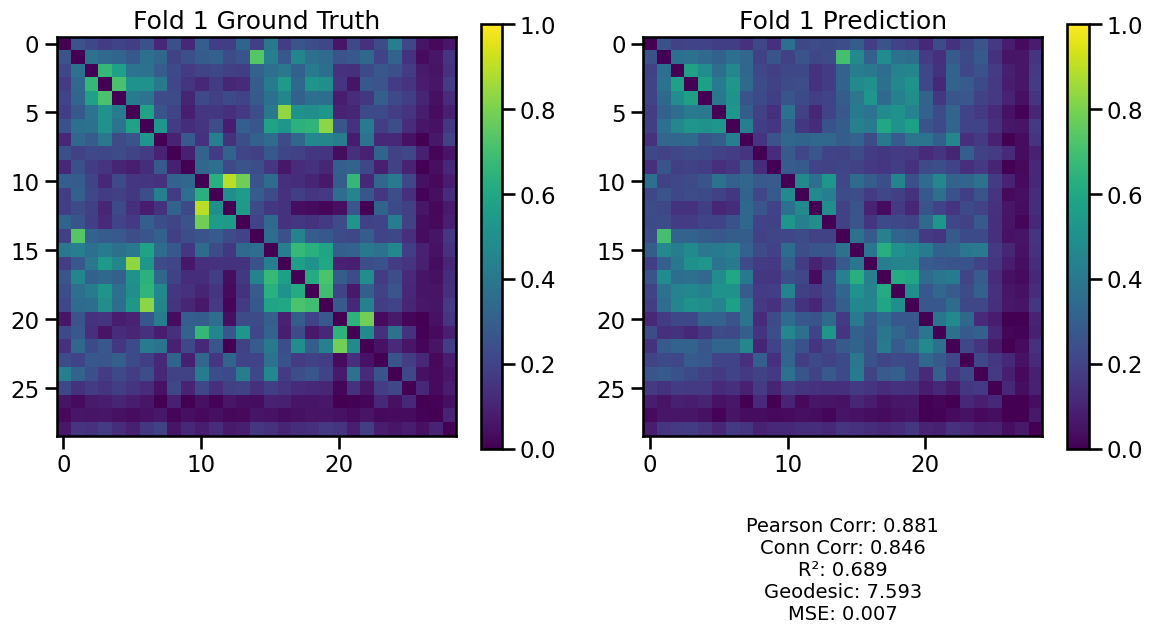

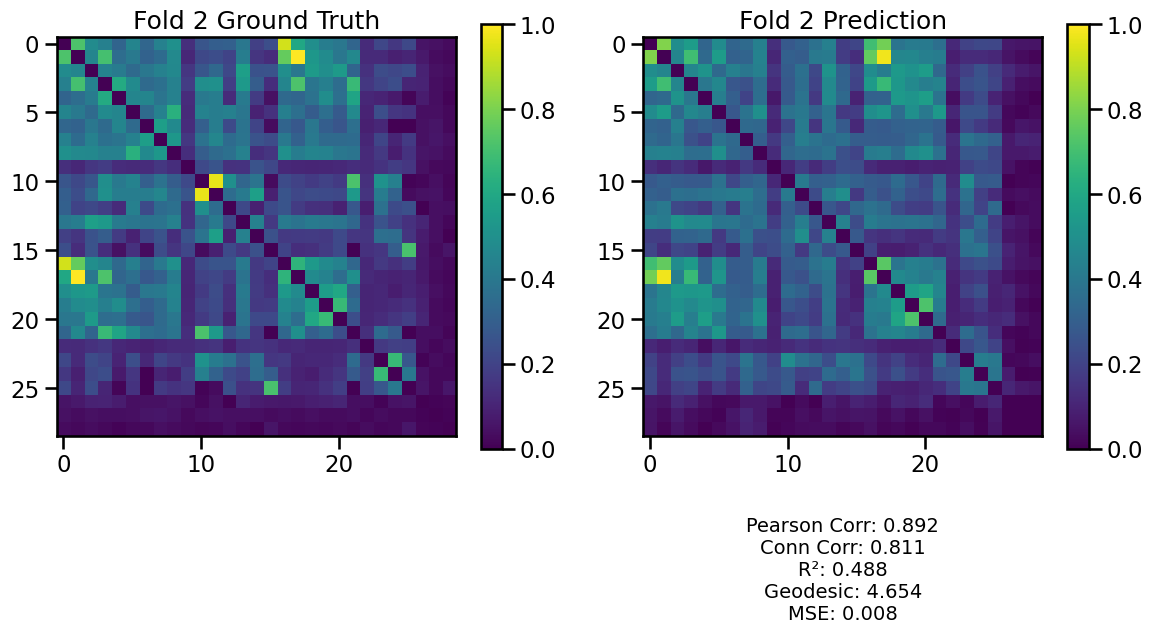

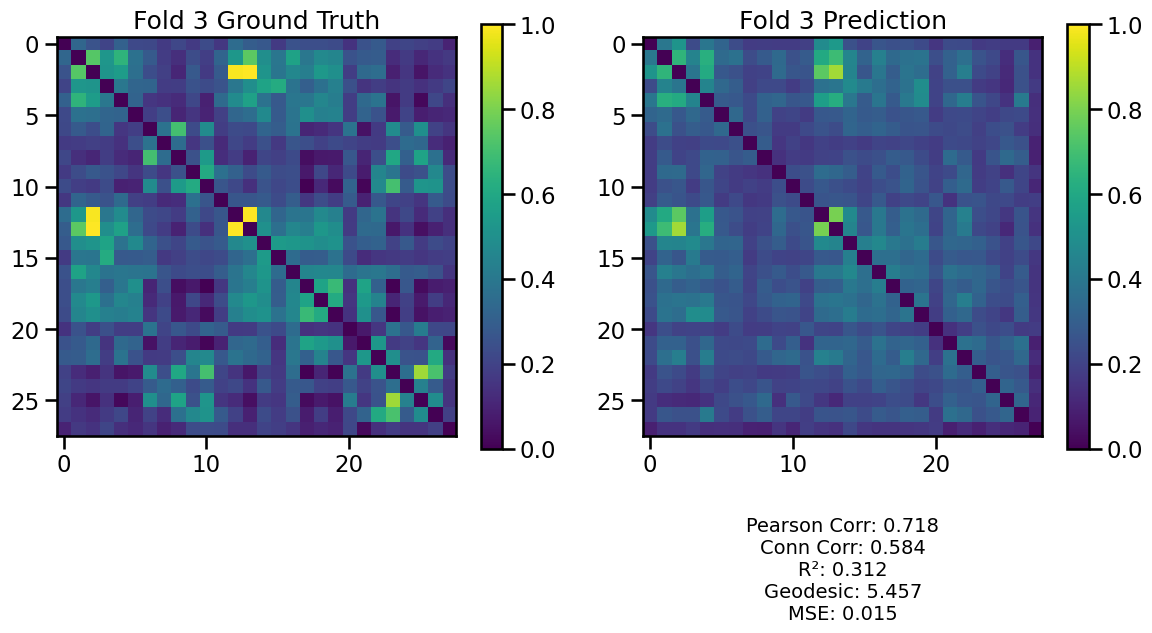

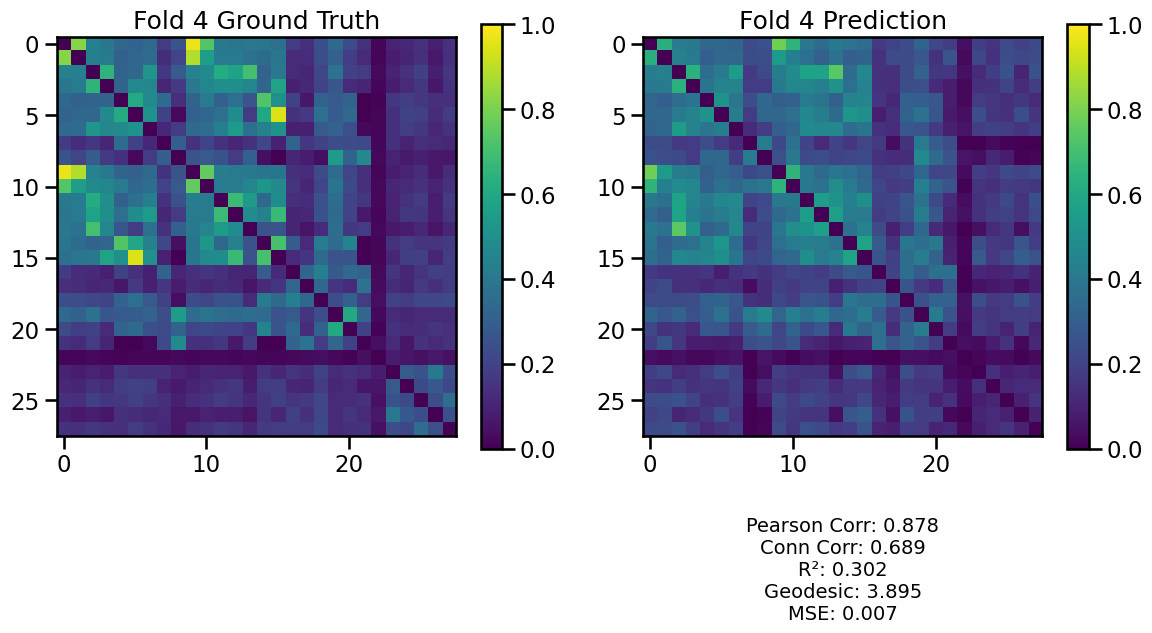

In [70]:
plot.plot_single_model_predictions_with_metrics(euclid_xgb_random_nonshared_sim_results)

Comparison to transcriptome for same split type

In [69]:
trans_sim_random_shared_xgb = multi_sim_run.open_pickled_results('single_sim_trans_bsearch_random_xgboost_useshared_trainshared.pickle')

plot.plot_single_model_predictions_with_metrics(trans_sim_random_shared_xgb)

In [64]:
trans_xgb_random_nonshared_sim_results = single_sim_run(cv_type='random',
                                              model_type='xgboost',
                                              feature_type='trans only',
                                              use_gpu=True,
                                              use_shared_regions=False,
                                              test_shared_regions=False, 
                                              save_sim=False,
                                              search_method='grid'
                                              )

Number of components explaining 95% of the variance: 34
Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...

 Test fold num: 1
(12070, 22106) (12070,) (812, 22106) (812,)
2
3
4
Processing fold 0...
Processing fold 1...
Processing fold 2...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.8, device=cuda, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=250, random_state=42, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6, tree_method=hist, verbosity=2; total time=   3.4s
[CV] END colsample_bytree=0.8, device=cuda, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=250, random_state=42, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6, tree_method=hist, verbosity=2; total time=   3.1s
[CV] END colsample_bytree=0.8, device=cuda, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=250, random_state=42, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6, tr

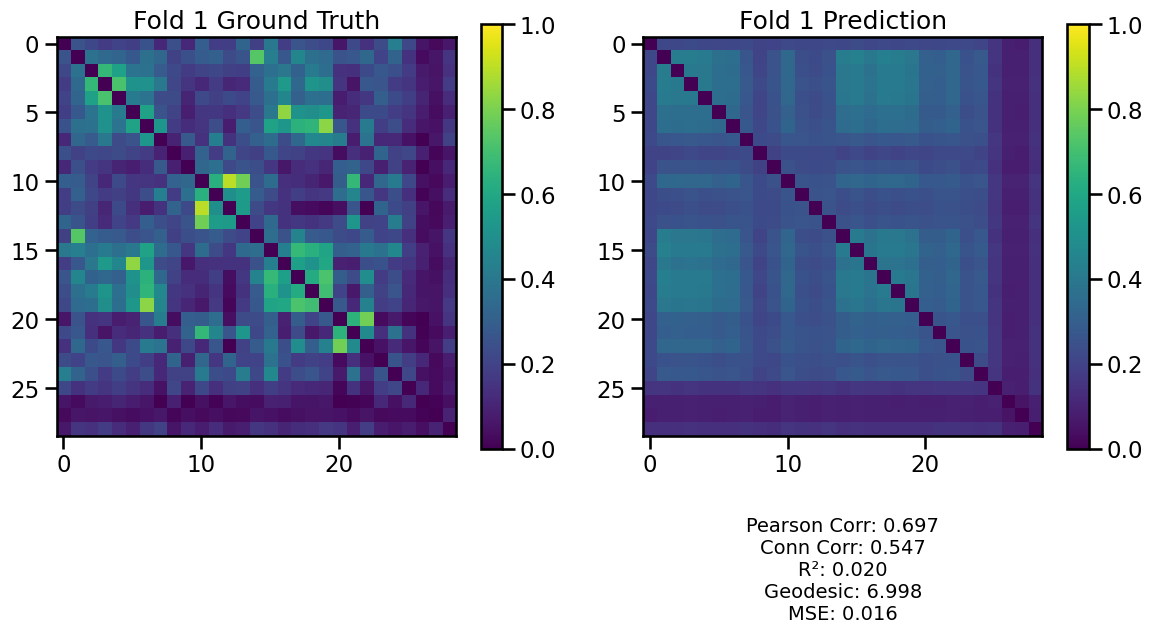

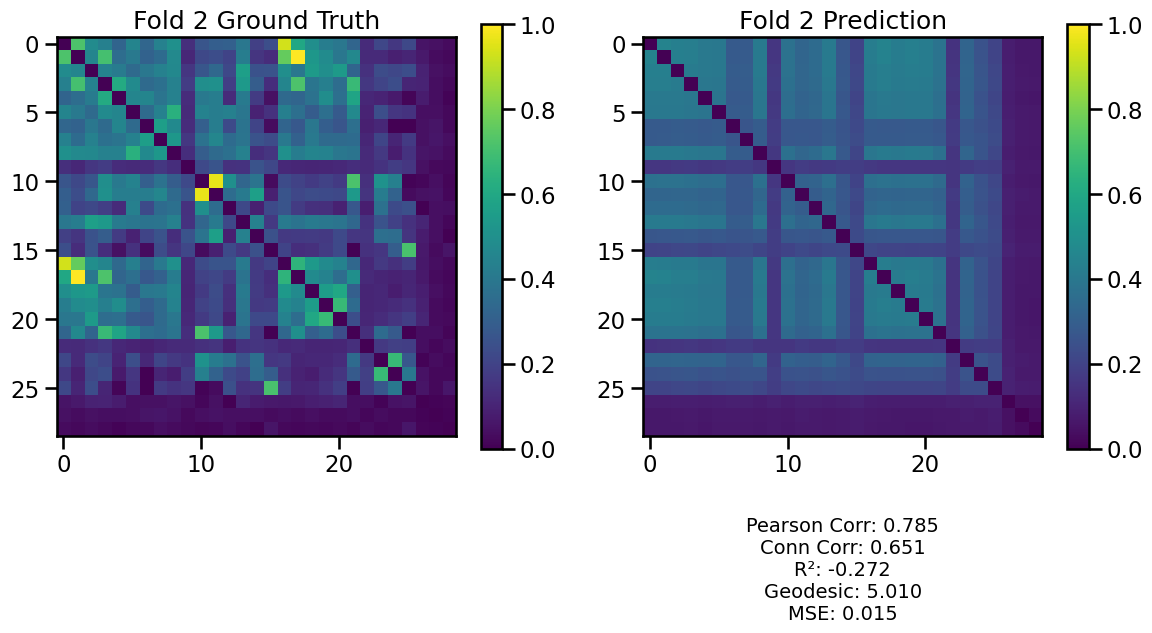

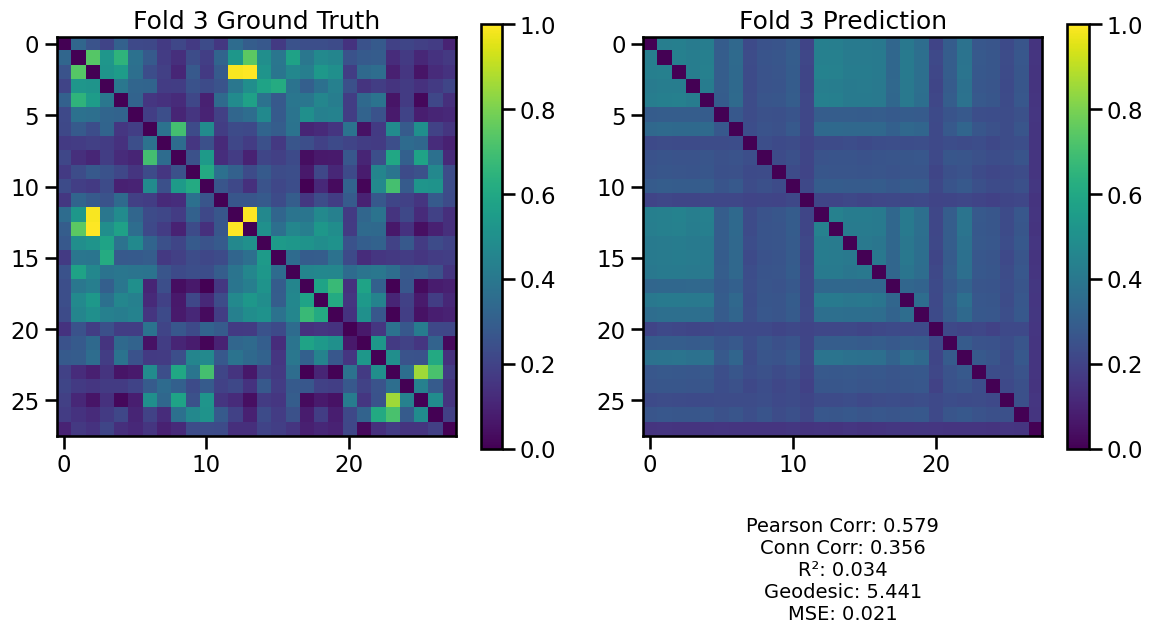

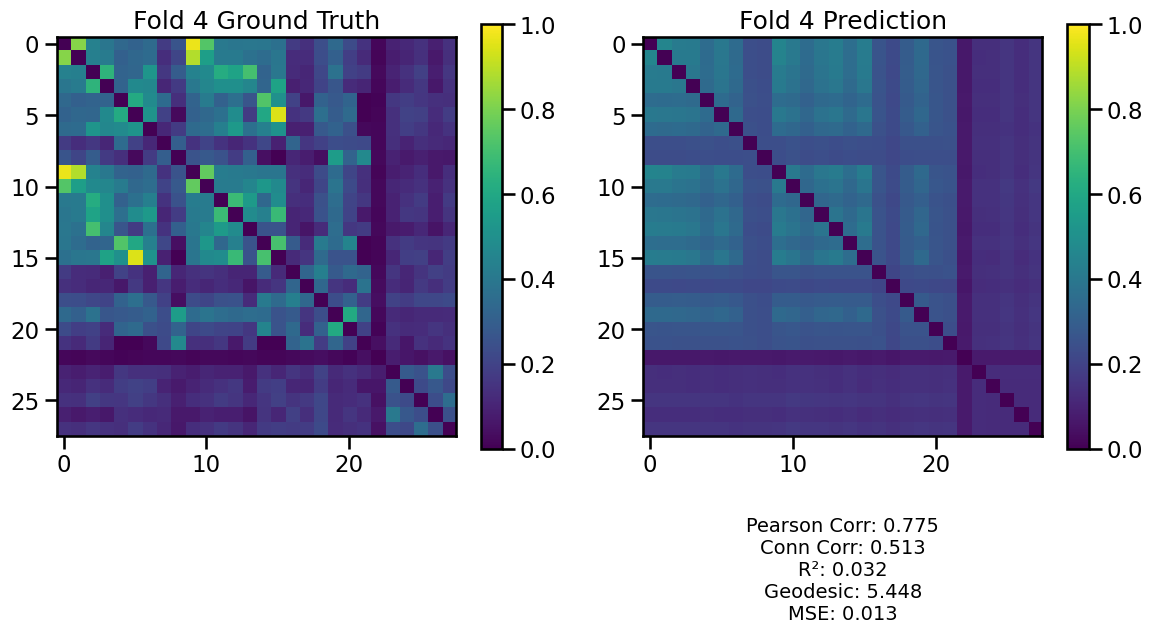

In [66]:
plot.plot_single_model_predictions_with_metrics(trans_xgb_random_nonshared_sim_results)

### Experiment Run for Structural Connectivity

In [11]:
structural_xgb_random_nonshared_sim_results = single_sim_run(cv_type='community',
                                              model_type='xgboost',
                                              feature_type='structural',
                                              use_gpu=True,
                                              use_shared_regions=False,
                                              test_shared_regions=False,
                                              save_sim=False,
                                              search_method='grid'
                                              )

Number of components explaining 95% of the variance: 34
Processing fold 0...
Processing fold 1...
Processing fold 2...

 Test fold num: 1
(6320, 228) (6320,) (1122, 228) (1122,)
2
3
Processing fold 0...
Processing fold 1...
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END colsample_bytree=1, device=cuda, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=250, random_state=42, reg_alpha=0, reg_lambda=0, subsample=1, tree_method=hist, verbosity=2; total time=   3.2s
[CV] END colsample_bytree=1, device=cuda, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=250, random_state=42, reg_alpha=0, reg_lambda=0, subsample=1, tree_method=hist, verbosity=2; total time=   2.5s

Grid Search CV Results:
Best Parameters:  {'colsample_bytree': 1, 'device': 'cuda', 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 250, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1, 'tree_meth

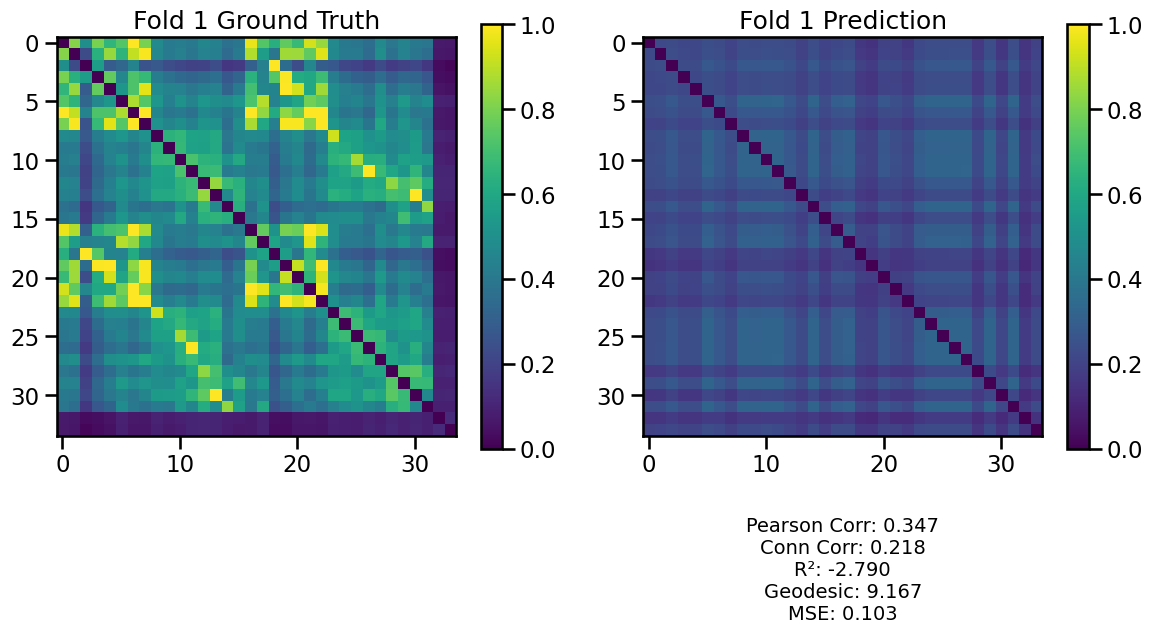

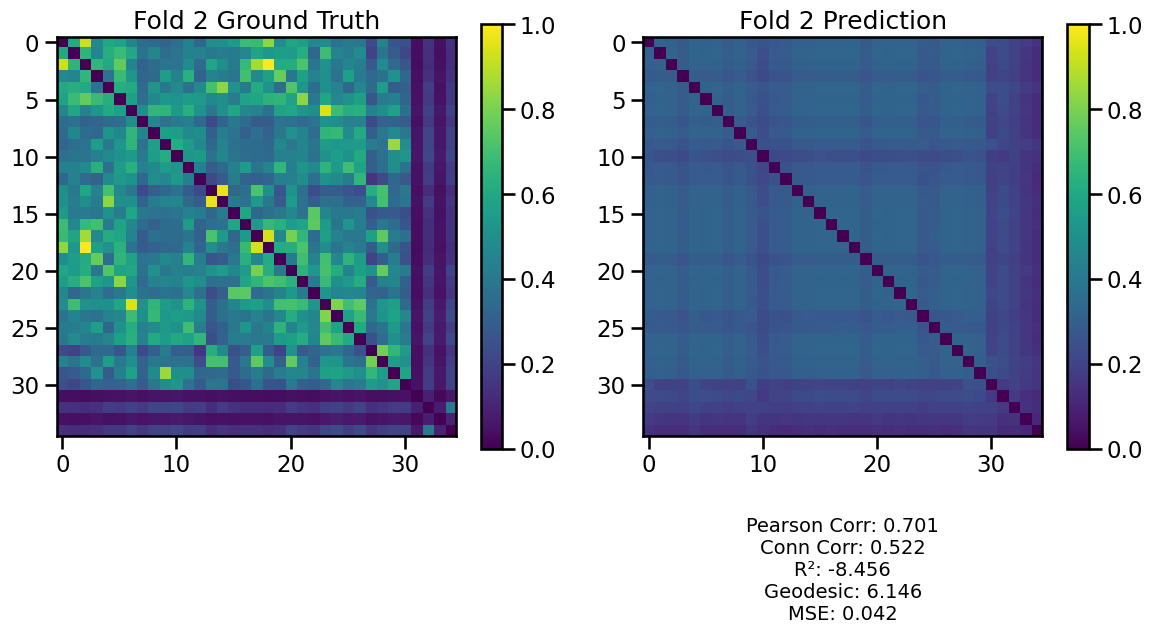

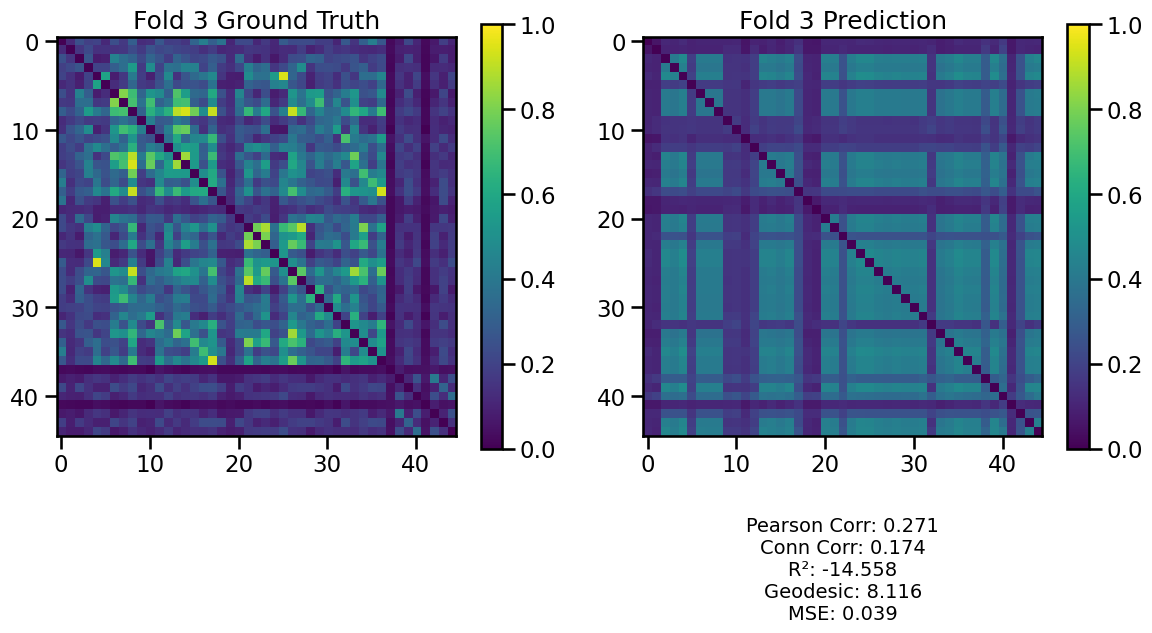

In [12]:
plot.plot_single_model_predictions_with_metrics(structural_xgb_random_nonshared_sim_results)

### Experiment Run for Transcriptome PCA

In [47]:
transPCA_xgb_random_nonshared_sim_results = single_sim_run(cv_type='random',
                                              model_type='xgboost',
                                              feature_type='trans only',
                                              summary_measure='PCA',
                                              use_gpu=True,
                                              use_shared_regions=False,
                                              test_shared_regions=False, 
                                              save_sim=False,
                                              search_method='grid'
                                              )

Number of components explaining 95% of the variance: 40
Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...

 Test fold num: 1
(7140, 80) (7140,) (812, 80) (812,)
2
3
4
Processing fold 0...
Processing fold 1...
Processing fold 2...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=1, device=cuda, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=250, random_state=42, reg_alpha=0, reg_lambda=0, subsample=1, tree_method=hist, verbosity=2; total time=   5.2s
[CV] END colsample_bytree=1, device=cuda, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=250, random_state=42, reg_alpha=0, reg_lambda=0, subsample=1, tree_method=hist, verbosity=2; total time=   5.1s
[CV] END colsample_bytree=1, device=cuda, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=250, random_state=42, reg_alpha=0, reg_lambda=0, subsample=1, tree_method=hist, verbosity=2; total tim

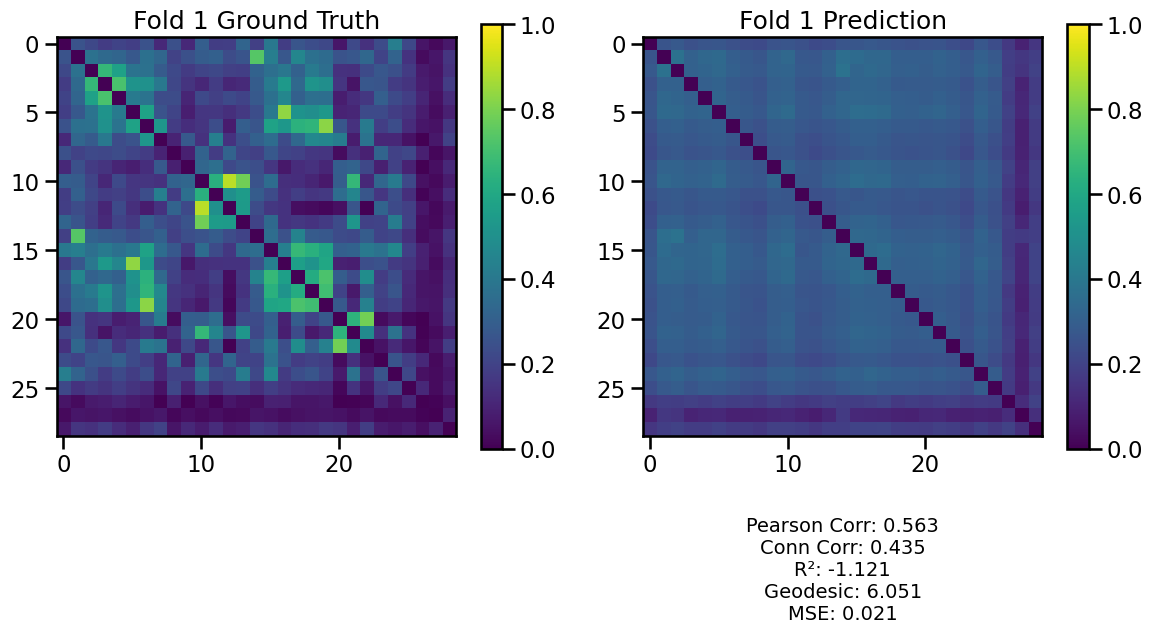

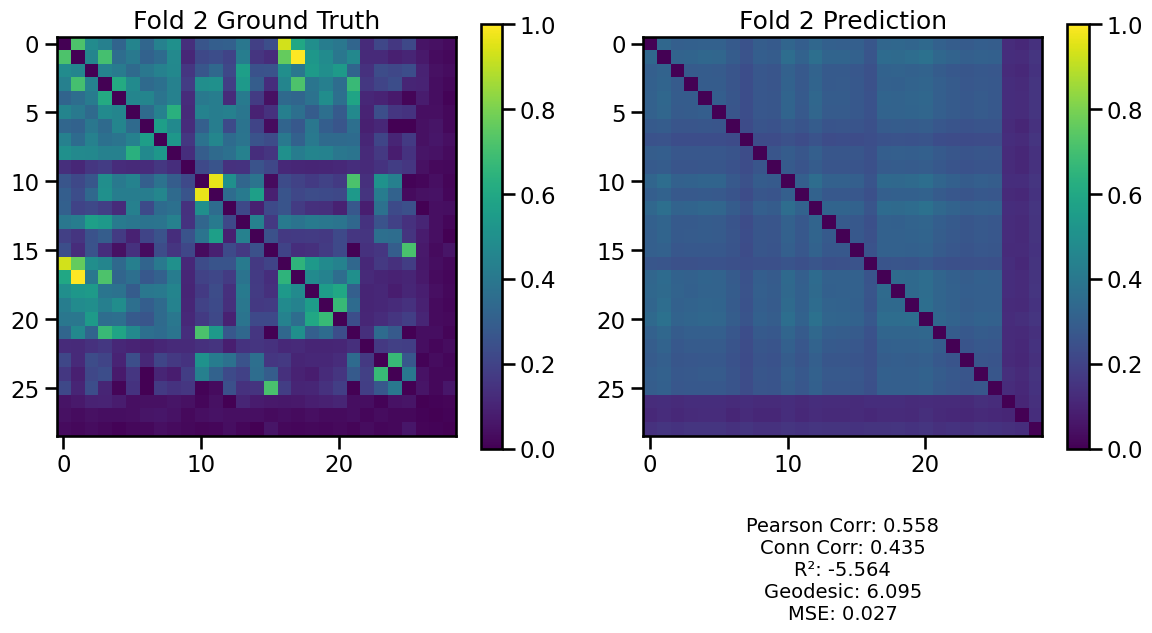

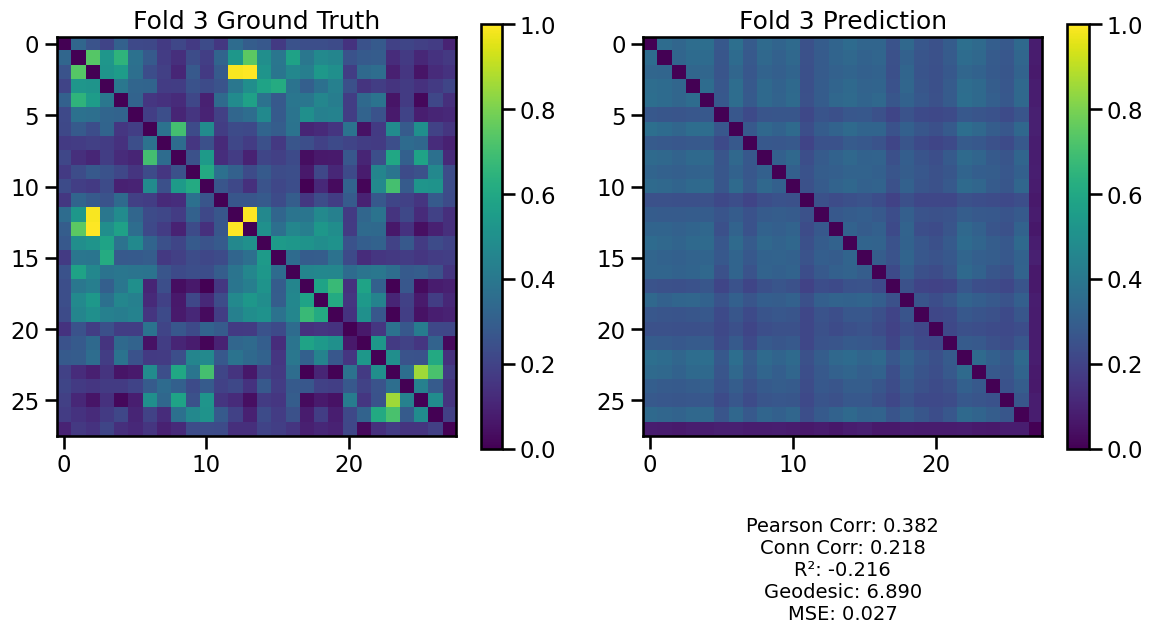

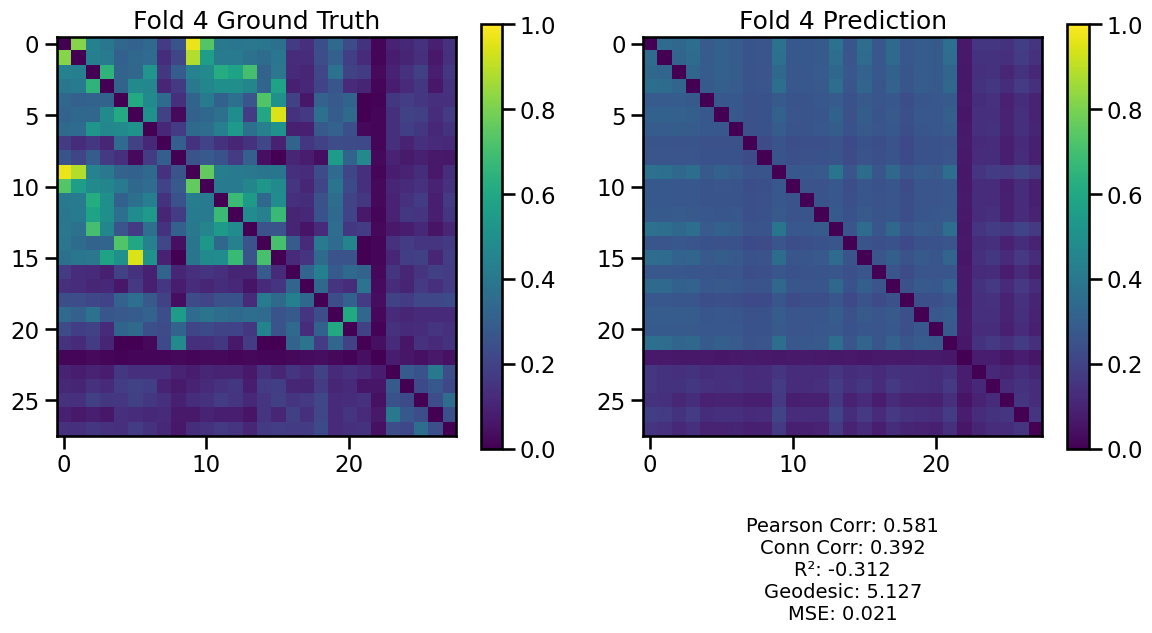

In [24]:
plot.plot_single_model_predictions_with_metrics(transPCA_xgb_random_nonshared_sim_results)

### Experiment Run for Transcriptome PCA+Kronecker

In [20]:
transPCAkron_xgb_random_nonshared_sim_results = single_sim_run(cv_type='random',
                                              model_type='xgboost',
                                              feature_type='trans only',
                                              summary_measure='PCA+kron',
                                              use_gpu=True,
                                              use_shared_regions=False,
                                              test_shared_regions=False, 
                                              save_sim=False,
                                              search_method='bayes'
                                              )

Number of components explaining 95.0% of the variance: 34
Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...

 Test fold num: 1
(7140, 1156) (7140,) (812, 1156) (812,)
2
3
4
Processing fold 0...
Processing fold 1...
Processing fold 2...
ACCELERATING
{'base_estimator': 'GP', 'acq_func': 'PI'}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END colsample_bytree=0.8, device=cuda, learning_rate=0.3, max_depth=4, n_estimators=250, n_gpus=-1, random_state=42, reg_alpha=0.1, reg_lambda=0.01, subsample=1, tree_method=gpu_hist, verbosity=0;, score=0.481 total time=   6.3s
[CV 2/3] END colsample_bytree=0.8, device=cuda, learning_rate=0.3, max_depth=4, n_estimators=250, n_gpus=-1, random_state=42, reg_alpha=0.1, reg_lambda=0.01, subsample=1, tree_method=gpu_hist, verbosity=0;, score=0.351 total time=   6.6s
[CV 3/3] END colsample_bytree=0.8, device=cuda, learning_rate=0.3, max_depth=4, n_estimators=250, n_gpus=-1, random_state=42, reg_alpha=0

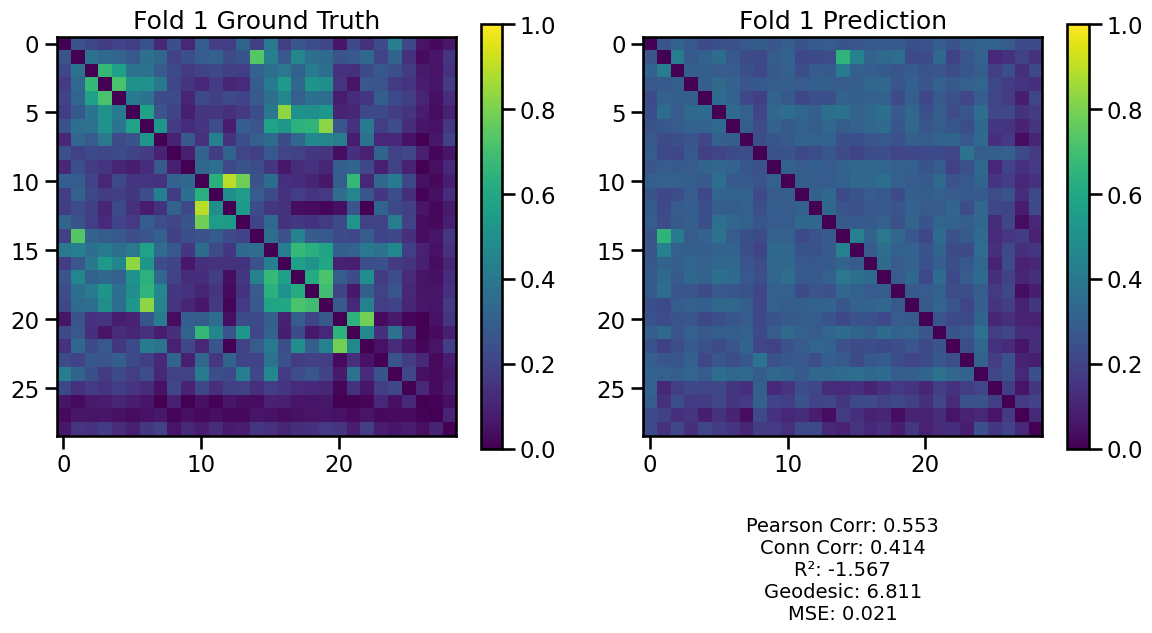

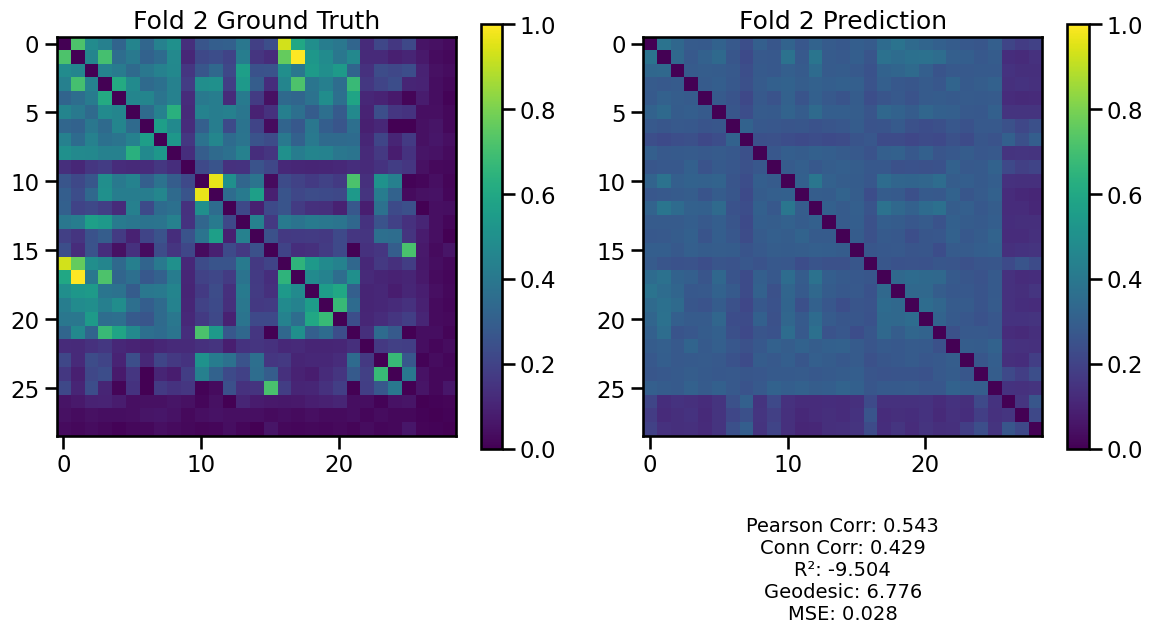

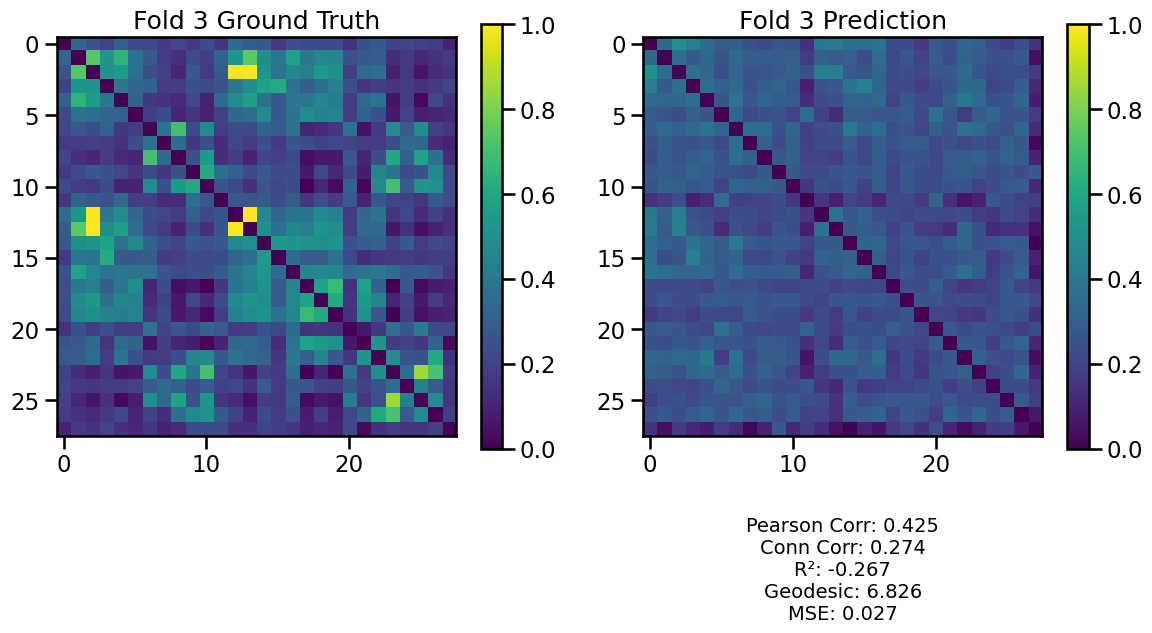

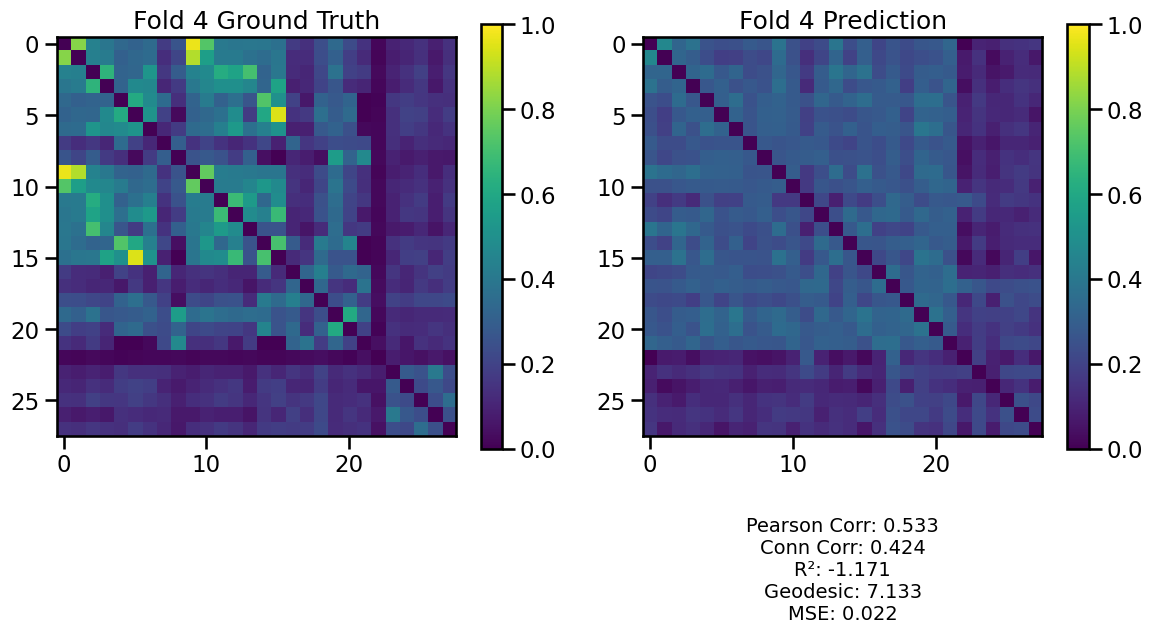

In [22]:
plot.plot_single_model_predictions_with_metrics(transPCAkron_xgb_random_nonshared_sim_results)

In [18]:
transPCAkron_xgb_community_nonshared_sim_results = single_sim_run(cv_type='community',
                                              model_type='xgboost',
                                              feature_type='trans only',
                                              summary_measure='PCA+kron',
                                              use_gpu=True,
                                              use_shared_regions=False,
                                              test_shared_regions=False, 
                                              save_sim=False,
                                              search_method='grid'
                                              )

Number of components explaining 95.0% of the variance: 34
Processing fold 0...
Processing fold 1...
Processing fold 2...

 Test fold num: 1
(6320, 1156) (6320,) (1122, 1156) (1122,)
2
3
Processing fold 0...
Processing fold 1...
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END colsample_bytree=1, device=cuda, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, random_state=42, reg_alpha=0, reg_lambda=0, subsample=1, tree_method=hist, verbosity=2; total time=  12.0s
[CV] END colsample_bytree=1, device=cuda, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, random_state=42, reg_alpha=0, reg_lambda=0, subsample=1, tree_method=hist, verbosity=2; total time=  10.1s

Grid Search CV Results:
Best Parameters:  {'colsample_bytree': 1, 'device': 'cuda', 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1, 'tree_

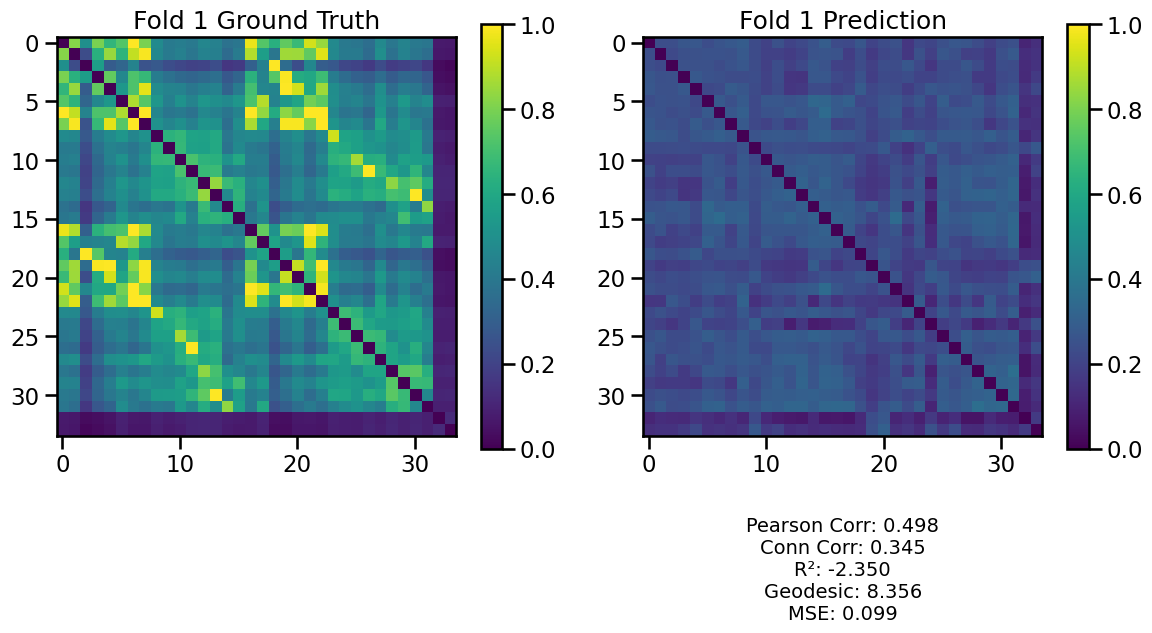

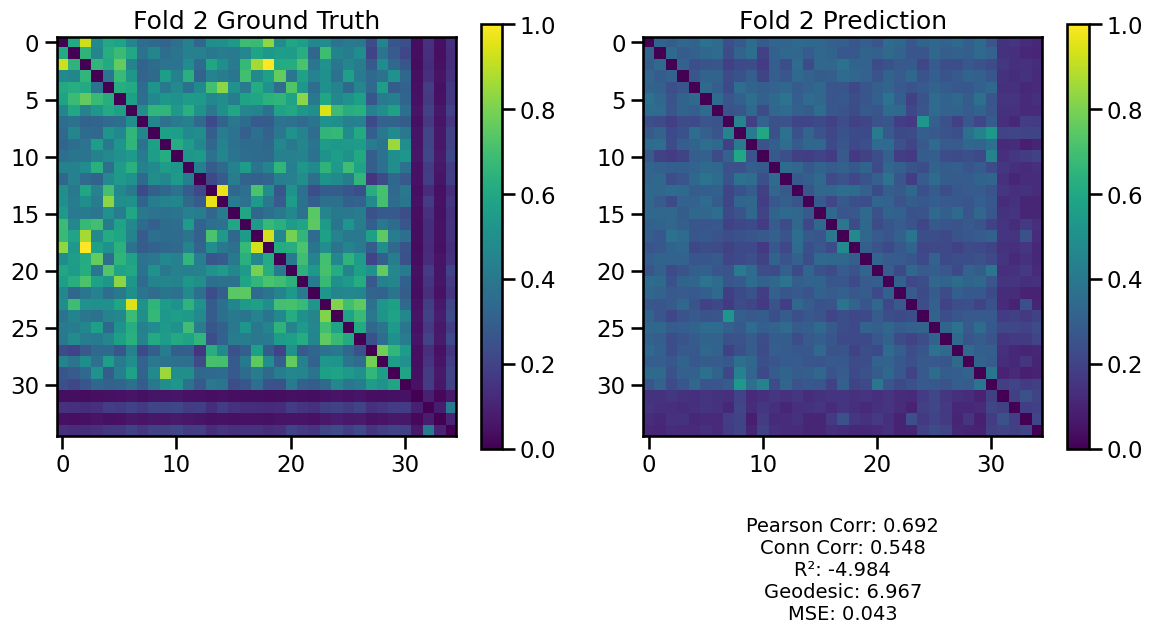

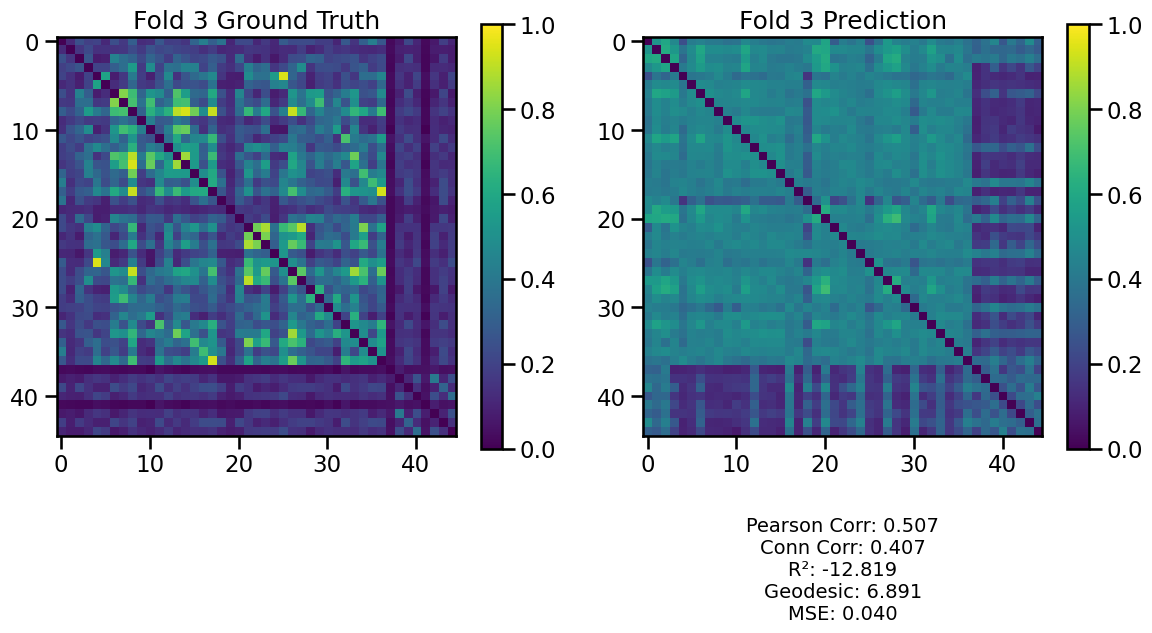

In [19]:
plot.plot_single_model_predictions_with_metrics(transPCAkron_xgb_community_nonshared_sim_results)

### Multi feature experiment run

In [163]:
custom_xgb_random_nonshared_sim_results = single_sim_run(
                                              cv_type='random',
                                              model_type='xgboost',
                                              feature_type=['transcriptomePCA', 'structural'],
                                              summary_measure=None,
                                              use_gpu=True,
                                              use_shared_regions=False,
                                              test_shared_regions=False,
                                              save_sim=False,
                                              search_method='bayes'
                                              )

Number of components explaining 95.0% of the variance: 34
self X shape (114, 148)
Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...

 Test fold num: 1
(7140, 296) (7140,) (812, 296) (812,)
2
3
4
Processing fold 0...
Processing fold 1...
Processing fold 2...
model build init 296
ACCELERATING
{'base_estimator': 'GP', 'acq_func': 'PI'}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
y_true shape: (812,)
y_pred shape: (812,)
[CV 1/3] END colsample_bytree=0.8, device=cuda, learning_rate=0.3, max_depth=4, n_estimators=250, n_gpus=-1, random_state=42, reg_alpha=0.1, reg_lambda=0.01, subsample=1, tree_method=gpu_hist, verbosity=0;, score=0.378 total time=   1.6s
y_true shape: (756,)
y_pred shape: (756,)
[CV 2/3] END colsample_bytree=0.8, device=cuda, learning_rate=0.3, max_depth=4, n_estimators=250, n_gpus=-1, random_state=42, reg_alpha=0.1, reg_lambda=0.01, subsample=1, tree_method=gpu_hist, verbosity=0;, score=0.175 total time=   0.3s
y_true sha

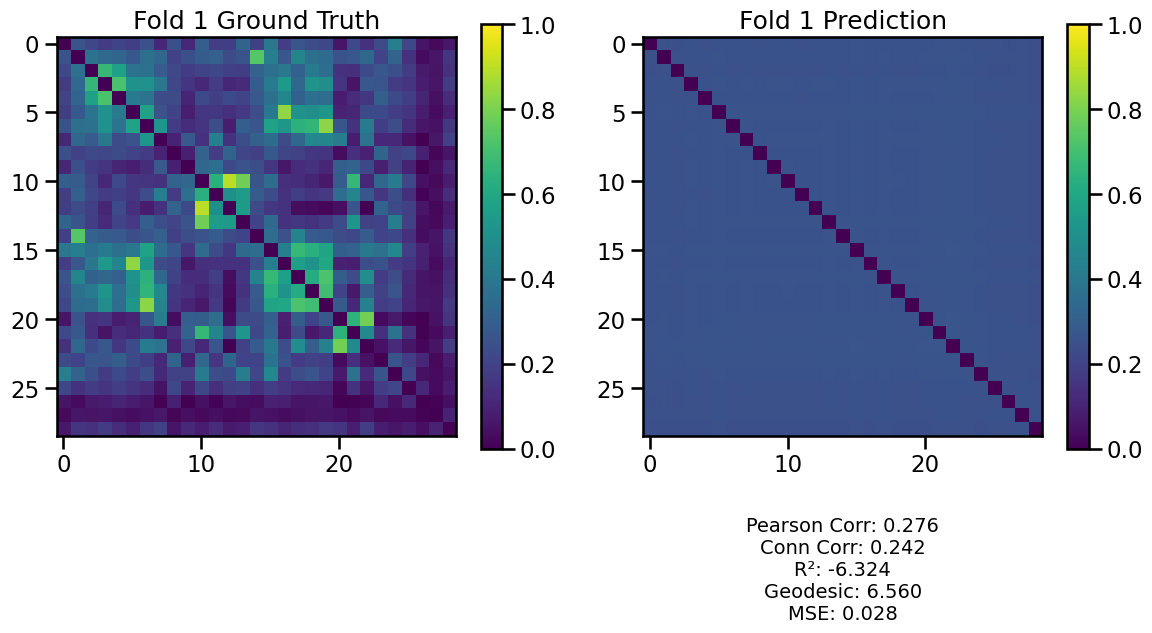

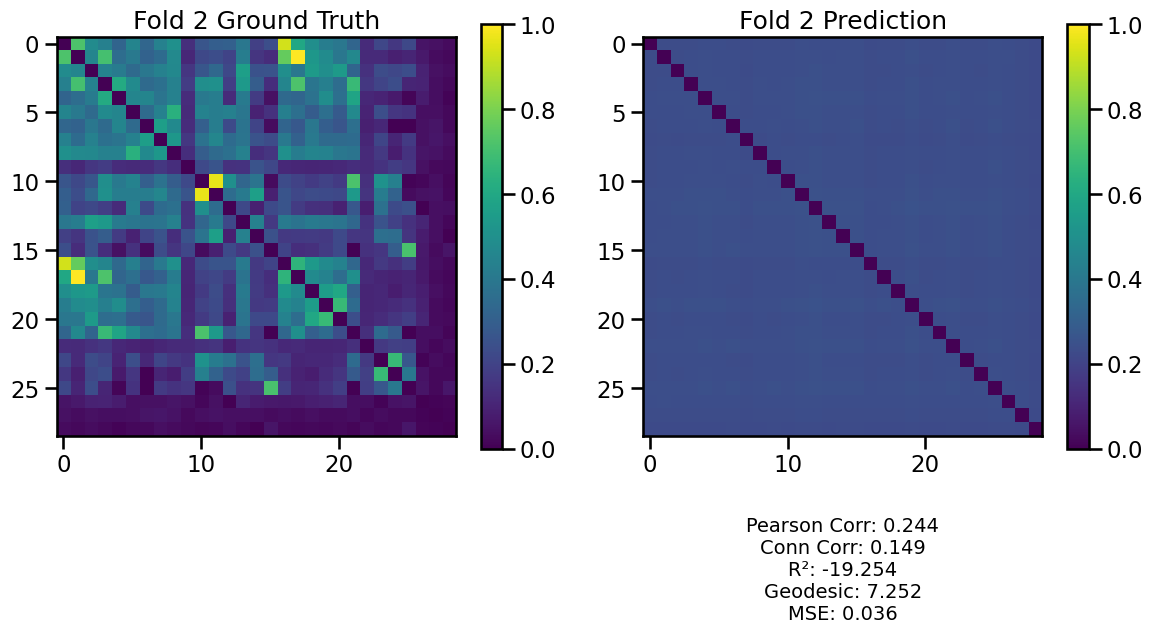

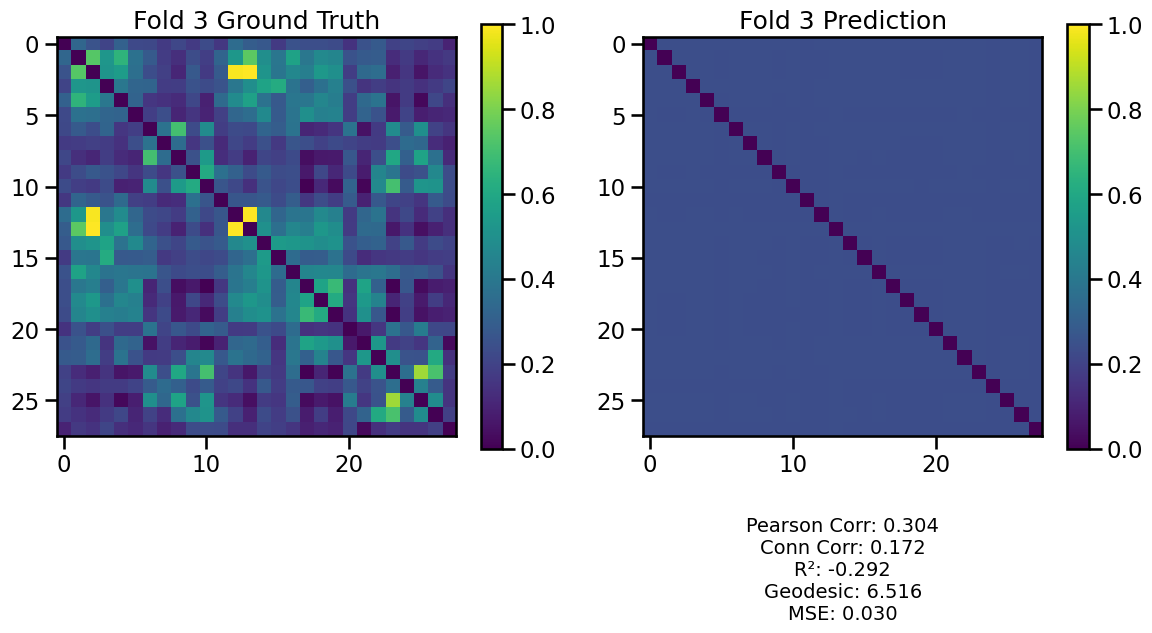

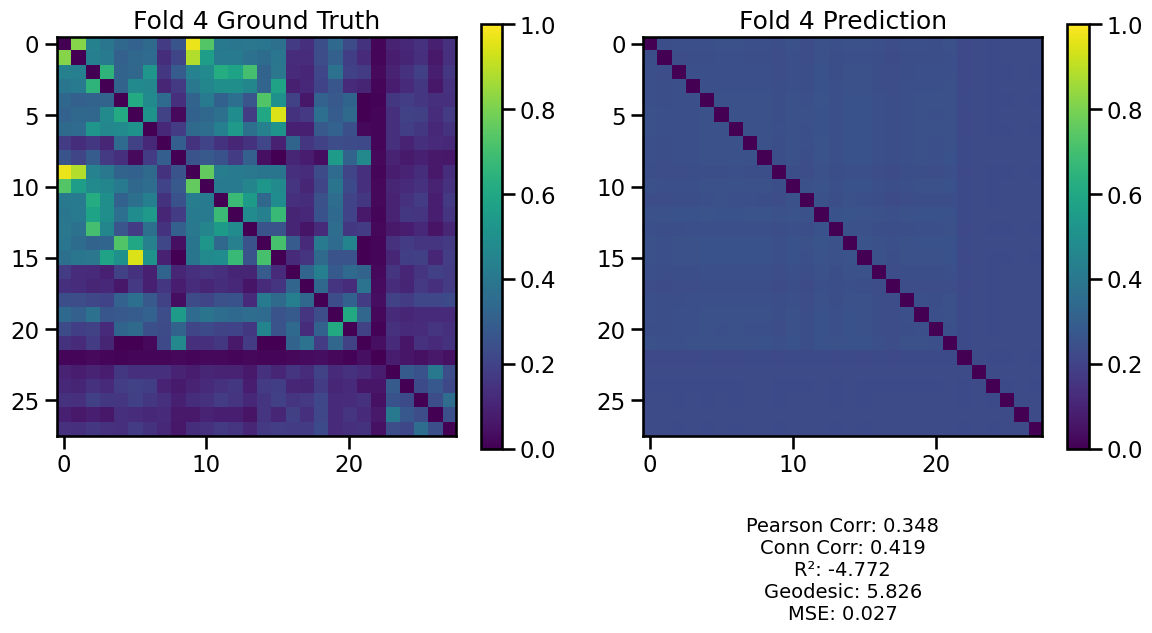

In [16]:
plot.plot_single_model_predictions_with_metrics(custom_xgb_random_nonshared_sim_results)